クラスター中心は
[[0.50076036 0.52011935]
 [0.50391614 0.30453223]
 [0.50486502 0.5145726 ]
 [0.52479216 0.53931299]
 [0.52604008 0.54079588]]
目的関数は0.10865701330738106
[0. 4. 1. 4. 0. 3. 3. 0. 2. 4. 0. 0. 3. 3. 2. 0. 2. 0. 2. 2. 0. 3. 3. 2.
 0. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


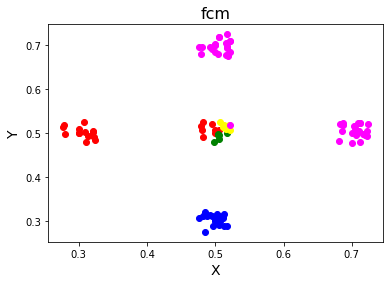

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

#クラスタ数宣言
cluster_number = 5
#max繰り返し回数の宣言
max_iter=1
#dfをnumpyで扱えるnp.ndarray変換
df = pd.read_csv("../HCM/input.csv",header=None)
X = df.values
np.seterr(divide='ignore', invalid='ignore')
#配列の行数、列数の格納
X_size,n_features = X.shape
#epsilonの定義
epsilon=0.0001
#前の中心と比較するために、仮に新しい重心を入れておく配列を用意
new_v = np.zeros((cluster_number, n_features))
#メンバーシップuを作成(配列初期値は０にしないとおかしくなる)
u = np.zeros((X_size,cluster_number))
new_u = np.zeros((X_size,cluster_number))
#距離の格納 d_ik
distances=np.zeros((X_size,cluster_number))

m=3
J=0
best_J = 0
v = X[np.random.choice(X_size,cluster_number)]

cluster = np.zeros(X_size)

#FCMアルゴリズム
for epoch in range(max_iter):
    #FCM2における最適解(new_uの導出)
    for i in range(X_size):    
        # データから各重心までの距離の二乗を計算
        distances[i] = np.sum((v - X[i]) ** 2, axis=1)
        #x_k != v_iの時
        if 0 not in distances[i]:
            for j in range(cluster_number):
                for k in range(cluster_number):
                    new_u[i][j] = new_u[i][j] + (distances[i][j]/distances[i][k])**(1/(m-1))
                new_u[i][j]=1/new_u[i][j]
        #x_k=v_iの時
        else:
            for j in range(cluster_number):
                if distances[i][j]==0:
                    new_u[i][j] = 1
                else:
                    new_u[i][j]=0
    #s = np.sum(new_u,axis=1)
    #print(s)
    
    #FCM3における最適解(new_vの導出)
    new_u_m=np.power(new_u,m)
    #分母計算
    v_denominator=np.sum(new_u_m,axis=0)
    #分子計算
    v_numerator = np.zeros((cluster_number,n_features))
    for i in range(cluster_number):
        for j in range(X_size):
            v_numerator[i]=v_numerator[i]+new_u_m[j][i]*X[j]
    for i in range(cluster_number):
        new_v[i] = v_numerator[i]/v_denominator[i]

    #vの収束条件
    v_difference = np.zeros((cluster_number,n_features))
    for i in range(cluster_number):
        for j in range (n_features):
            v_difference[i][j]=np.abs(new_v[i][j]-v[i][j])

    #uの収束条件
    u_difference = np.zeros((X_size,n_features))
    for i in range(X_size):
        for j in range (n_features):
            u_difference[i][j]=np.abs(new_u[i][j]-u[i][j])   

    #目的関数の計算
    for i in range(X_size):
        for j in range(cluster_number):
            J=J+((new_u[i][j])**m)*(distances[i][j])
     
    #目的関数の値が良いものに更新していく
    if J < best_J or best_J==0:
        best_J = J
        best_u = np.copy(new_u)
        best_v = np.copy(new_v)
    #値のリセット
    J=0
    u = np.copy(new_u)
    v = np.copy(new_v)
    new_u = np.zeros((X_size,cluster_number))
    
    #収束条件
    if np.amax(v_difference) < epsilon or np.amax(u_difference) < epsilon:  
        break
print("クラスター中心は")
print(best_v)
print("目的関数は"+str(best_J))


#帰属クラスターの決定と格納
for i in range(X_size):
    cluster[i] = np.argsort(best_u[i])[4]
print(cluster)
#matplotlibに描写(2次元データ)
if n_features == 2:
    colors = ['red', 'blue', 'green','yellow','fuchsia']

    fig = plt.figure()
    ax = fig.add_subplot(111)

    for i in range(cluster_number):
        ax.scatter(X[:, 0][cluster==i], X[:, 1][cluster==i], color=colors[i])

    ax.set_title('fcm', size=16)
    ax.set_xlabel("X", size=14)
    ax.set_ylabel("Y", size=14)

    plt.show()
    fig.savefig("fcm2d.pdf")

    #pandasで分割結果を記入
    df["cluster"]=cluster
    df["u1"]=u[:,0]
    df["u2"]=u[:,1]
    df["u3"]=u[:,2]
    df["u4"]=u[:,3]
    df["u5"]=u[:,4]
    df.to_csv('fcm2d.csv')
    #目的関数を記入
    with open ('fcm2d.csv','a') as f:
        writer = csv.writer(f)
        writer.writerow(["J",best_J])

In [5]:
distances[1]

array([1.55686824e-01, 3.74868807e-02, 8.02076865e-02, 3.59465831e-05,
       7.67647493e-02])

In [7]:
v_denominator=np.sum(new_u_m,axis=0)

In [9]:
v_denominator

array([12.87704788,  9.83458615, 11.06577593, 10.74953387,  8.14734458])

In [11]:
new_u

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0.